First attempt of a HMM to generate tracks. We go with the case of tracks either following a Brownian motion ($s_1$) or being attached to microtubulus ($s_2$), i.e. $K=2$ states. The transition between the states are governend by a state transition matrix $\mathbf{T}$, emission probabilities of observables $O$ given state $s_k$ are collected in the emision matrix $\mathbf{E}$.

In [1]:
import numpy as np
from sklearn.preprocessing import normalize  

T = np.array([[0.99, 0.01],[0.1, 0.9]]) # assuming that Brownian motion is dominating
pi = np.array([0.95, 0.05]) # The prior probability of being in a s_1 and s_2 respectively

The observables $O_{i,t}$, where $i$ denotes different tracks and $t$ different timesteps, are the distance travelled between time $t-1$ and $t$ ($l_{i,t}$) and the relative turning angle of the track ($\alpha_{i,t}$). For $l_{i,t}$ we in both casses draw from a log-normal distribution:
\begin{equation}
    p(l_{i,t}|s_j) = lognorm(\mu_{l,j},\sigma_{l,j})
\end{equation}
For $\alpha_{i,t}$ we have different distributions, not just by parameters, for the two states. Brownian motion is described by
\begin{equation}
    p(\alpha_{i,t}|s_1) = Uniform(-pi,pi).
\end{equation}
In state $s_2$ the movement is going to be pretty straight, therefore this is drawn from
\begin{equation}
    p(\alpha_{i,t}|s_2) = Normal(0,\sigma_{\alpha,2}).
\end{equation}

In [2]:
def generate_sequence_hmm(N, T, pi, mu_l, sigma_l, sigma_alpha_2, details=False):
    """Generate observation and state sequence from given HMM

    Notebook: C5/C5S3_HiddenMarkovModel.ipynb

    Args:
        N (int): Number of observations to be generated
        T (np.ndarray): State transition probability matrix of dimension K x K
        pi (np.ndarray): Initial state distribution of dimension K
        mu_l (np.ndarray): Means of the lognormal distributions for each state
        sigma_l (np.ndarray): Standard deviation of the lognormal distributions for each state
        sigma_alpha_2 (float): Standard deviation of the directed movement in state 2
        details (bool): If "True" then shows details (Default value = False)

    Returns:
        O (np.ndarray): Observation sequence of length N
        S (np.ndarray): State sequence of length N
    """
    assert N > 0, "N should be at least one"
    K = T.shape[1]
    assert K == T.shape[0], "T should be an K-square matrix"
    assert K == pi.shape[0], "Dimension of pi should be K"
    assert K == mu_l.shape[0], "Dimension of means should be K"

    O = np.zeros([N,2], float)
    S = np.zeros(N, int)
    for n in range(N):
        if n == 0:
            i = np.random.choice(np.arange(K), p=pi)
        else:
            i = np.random.choice(np.arange(K), p=T[i, :])
        l = np.random.lognormal(mu_l[i], sigma_l[i])
        if i == 0:
            alpha = np.random.uniform(-np.pi, np.pi)
        else:
            alpha = np.random.normal(0, sigma_alpha_2)
            
        S[n] = i
        O[n] = np.array([l, alpha])
        if details:
            print('n = %d, S[%d] = %d, O[%d] = %d' % (n, n, S[n], n, O[n]))
    return O, S

In [3]:
from numba import jit
import scipy.stats as sstats

@jit(nopython=True)
def lognorm_pdf(x, mu, sigma):
    ''' PDF of the log-normal distribution.'''
    out = 1.0/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(sigma**2))
    
    return out

In [4]:
@jit(nopython=True)
def norm_pdf(x, mu, sigma):
    #print(x)
    #print(mu)
    #print(sigma)
    out = 1.0/(sigma*np.sqrt(2*np.pi))*np.exp(-((x-mu)**2)/(sigma**2))
    #if out < 10**(-25):
    #    out < 10**(-25)
    #print(out)
    return out

In [5]:
@jit(nopython=True)
def p_o_G_s(o, s, mu_l, sigma_l, sigma_alpha_2):
    p_l = lognorm_pdf(o[0], mu_l[s], sigma_l[s]) 
    if s == 0:
        p_alpha = 1/(2*np.pi)
    else:
        p_alpha = norm_pdf(o[1], 0.0, sigma_alpha_2)
    #print(p_l)
    #print(p_alpha)
    p_o_G_s = p_l*p_alpha
    
    if p_o_G_s < 10**(-20):
        p_o_G_s = 10**(-20)
    
    return p_o_G_s
    

In [6]:
@jit(nopython=True)
def p_olog_G_s(o, s, mu_l, sigma_l, sigma_alpha_2):
    p_l = norm_pdf(o[0], mu_l[s], sigma_l[s]) 
    #print(o[0])
    #
    if s == 0:
        p_alpha = 1/(2*np.pi)
    else:
        p_alpha = norm_pdf(o[1], 0.0, sigma_alpha_2)
    #print(p_l)
    #print(p_alpha)
    p_o_G_s = p_l*p_alpha
    if p_o_G_s < 10**(-20):
        p_o_G_s = 10**(-20)
    #print(p_o_G_s)
    return p_o_G_s

In [7]:
@jit(nopython=True)
def viterbi(T, pi, mu_l, sigma_l, sigma_alpha_2, O):
    """Viterbi algorithm for solving the uncovering problem

    Notebook: C5/C5S3_Viterbi.ipynb

    Args:
        T (np.ndarray): State transition probability matrix of dimension K x K
        pi (np.ndarray): Initial state distribution  of dimension K
        O (np.ndarray): Observation sequence of length N

    Returns:
        S_opt (np.ndarray): Optimal state sequence of length N
        D (np.ndarray): Accumulated probability matrix
        E (np.ndarray): Backtracking matrix
    """
    K = T.shape[0]    # Number of states
    N = len(O)  # Length of observation sequence

    # Initialize D and E matrices
    D = np.zeros((K, N)).astype(np.float64)
    E = np.zeros((K, N-1)).astype(np.int32)
    D[:, 0] = pi #np.multiply(C, B[:, O[0]])

    # Compute D and E in a nested loop
    for n in range(1, N):
        #if abs(O[n,1])<0.2:
        #    print(O[n])
        for i in range(K):
            temp_product = np.multiply(T[:, i], D[:, n-1])
            D[i, n] = np.max(temp_product) * p_o_G_s(O[n], i, mu_l, sigma_l, sigma_alpha_2)
            E[i, n-1] = np.argmax(temp_product)
            #if abs(O[n,1])<0.2:
            #    print(p_o_G_s(O[n], i, mu_l, sigma_l, sigma_alpha_2))

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    return S_opt, D, E

In [8]:
@jit(nopython=True)
def Baum_Welch(O, T0, pi0, mu_l0, sigma_l0, sigma_alpha_2_0):
    O = O[np.isfinite(O[:,0])]
    K = T.shape[0]    # Number of states
    N = len(O)  # Length of observation sequence
    
    alpha = np.zeros((K, N)).astype(np.float64)
    alpha_hat = np.zeros((K, N)).astype(np.float64)
    beta = np.ones((K, N)).astype(np.float64)
    pi_new = np.ones((K)).astype(np.float64)
    
    #print(O[0])
    alpha[:, 0] = pi*np.array([p_olog_G_s(O[0], 0, mu_l0, sigma_l0, sigma_alpha_2_0), p_olog_G_s(O[0], 1, mu_l0, sigma_l0, sigma_alpha_2_0)])
    #print(alpha[:, 0])
    alpha_hat_denom = np.sum(alpha[:, 0])
    #print(alpha_hat_denom)
    for k in range(K):
        alpha_hat[k, 0] = alpha[k, 0]/alpha_hat_denom
    #print(alpha_hat[:,0])
    for n in range(1, N):
        for k in range(K):
            alpha_hat[k, n] = p_olog_G_s(O[n], k, mu_l0, sigma_l0, sigma_alpha_2_0)*np.sum(alpha_hat[:, n-1]*T0[k,:])
            #print(O[n])
            #print(p_olog_G_s(O[n], k, mu_l0, sigma_l0, sigma_alpha_2_0))
        alpha_hat_denom = np.sum(alpha_hat[:, n])
        #print(p_olog_G_s(O[n], 0, mu_l0, sigma_l0, sigma_alpha_2_0))
        for k in range(K):
            alpha_hat[k, n] = alpha_hat[k, n]/alpha_hat_denom
            
    #print(alpha_hat)
    for n in range(N-2, -1, -1):
        d_t = 0.0
        for k in range(K):
            beta[k, n] = np.sum(beta[:, n+1]*T[k,:]*np.array([p_olog_G_s(O[n+1], 0, mu_l0, sigma_l0, sigma_alpha_2_0), p_olog_G_s(O[n+1], 1, mu_l0, sigma_l0, sigma_alpha_2_0)]))
            d_t = d_t + beta[k, n]
        d_t = 1.0/d_t
        beta[:,n] = d_t
         
    #print(beta)   
    gamma_denom = np.sum(alpha_hat*beta, axis=0) 
    gamma = alpha_hat*beta
    #print(gamma)
    for k in range(K):
        gamma[k] = gamma[k]/gamma_denom
    
    #print(gamma)
    epsilon = np.zeros((K, K, N-1)).astype(np.float64)
    for n in range(N-1):
        for k in range(K):
            for k2 in range(K):
                epsilon[k, k2, n] = alpha_hat[k, n]*T0[k,k2]*beta[k2,n+1]*p_olog_G_s(O[n+1], k2, mu_l0, sigma_l0, sigma_alpha_2_0)
    #print(epsilon)   
    epsilon_denom = np.zeros((N-1)).astype(np.float64)
    for k in range(K):
        for k2 in range(K):
             epsilon_denom += epsilon[k,k2]
    
    for k in range(K):
        for l in range(K):
            epsilon[k,l] = epsilon[k,l]/epsilon_denom
    
    
    
    for k in range(K):
        pi_new[k] = np.mean(gamma[k])
    #print(pi_new)
    mu_l_new = np.zeros(K).astype(np.float64)
    sigma_l_new = np.zeros(K).astype(np.float64)
    #sigma_alpha2_new = np.sqrt(np.sum((O[:,1])**2*gamma[1])/np.sum(gamma[1]))
    sigma_alpha2_new = sigma_alpha_2_0
    T_new = np.zeros((K,K)).astype(np.float64)
    for k in range(K):
        mu_l_new[k] = np.sum(O[:,0]*gamma[k])/np.sum(gamma[k])
        sigma_l_new[k] = np.sqrt(np.sum((O[:,0]-mu_l0[k])**2*gamma[k])/np.sum(gamma[k]))
        T_denom = np.sum(gamma[k,:-1])
        for k2 in range(K):
            T_new[k,k2] = np.sum(epsilon[k,k2])/T_denom
    for k in range(K):
        T_new[k] = T_new[k]/np.sum(T_new[k])
    if np.isnan(T_new).any():
        #print('T has NaN')
        T_new = 0.5*np.ones((2,2))
    sigma_l_new = sigma_l_new + 0.0000001
    
    #if np.isnan(gamma).any():
    #if not np.isfinite(mu_l_new[0]):
    #    print(O[:,0])
    #    print(gamma)
        #print(norm_pdf(O[10,0], mu_l0[0], sigma_l0[0]) )
    #print(mu_l_new)
    #print(sigma_l_new)
    #print(sigma_alpha2_new)
    #print(T_new)
                  
    return mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new
    

In [9]:
def convert_to_cartesian(o):
    X = np.zeros(o.shape, dtype=float)
    X[:,1] = np.cumsum(o[:,1])
    X[:,0] = np.cumsum(o[:,0]*np.cos(X[:,1]))
    X[:,1] = np.cumsum(o[:,0]*np.sin(X[:,1]))
    
    return X

In [10]:
mu_l = np.array([0.2, 0.2])
sigma_l = np.array([0.25, 0.25])
sigma_alpha_2 = 0.1
o, s = generate_sequence_hmm(100, T, pi, mu_l, sigma_l, sigma_alpha_2)

In [11]:
o.shape

(100, 2)

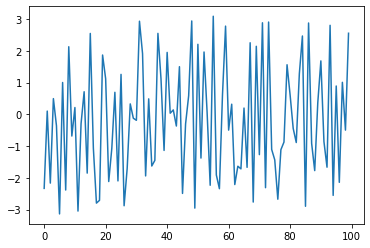

In [12]:
import pylab as plt
plt.plot(o[:,1])

In [13]:
X = convert_to_cartesian(o)

0


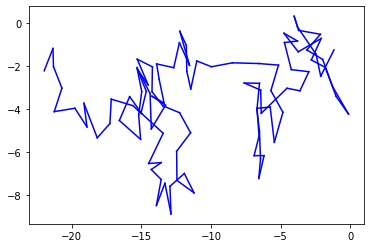

In [14]:
import seaborn as sns
s_1_idx = (s==0)
s_2_idx = (s==1)
print(np.sum(s_2_idx))
for ii in range(X.shape[0]-1):
    if s[ii+1] == 0:
        plt.plot(X[ii:ii+2,0], X[ii:ii+2,1], c='blue')
    else:
        plt.plot(X[ii:ii+2,0], X[ii:ii+2,1], c='red')
plt.savefig('/home/svensson/VMshared/HMM stuff/example_track6_GT.png')

In [15]:
s_est, D, E = viterbi(T, pi, mu_l, sigma_l, sigma_alpha_2, o)

In [16]:
o_log = np.copy(o[:])
o_log[:,0] = np.log(o[:,0])

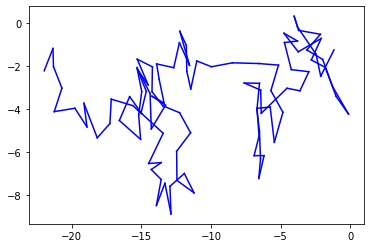

In [17]:
s_1_idx = (s_est==0)
s_2_idx = (s_est==1)
for ii in range(X.shape[0]-1):
    if s_est[ii+1] == 0:
        plt.plot(X[ii:ii+2,0], X[ii:ii+2,1], c='blue')
    else:
        plt.plot(X[ii:ii+2,0], X[ii:ii+2,1], c='red')
plt.savefig('/home/svensson/VMshared/HMM stuff/example_track6_Viterbi_fitted_all.png')

In [18]:
mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log, T, pi, mu_l, sigma_l, sigma_alpha_2)
for ii in range(10):
    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log, T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)

In [19]:
res_directory = {}

In [20]:
s_est, D, E = viterbi(T, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new, o)

In [21]:

T0 = np.copy(T[:])
mu_l0 = np.copy(mu_l[:])+np.random.uniform(0,4,size=2)
sigma_l0 = np.copy(sigma_l[:])+np.random.uniform(0,3,size=2)
sigma_alpha2_0 = sigma_alpha_2+1.5
pi0 = np.copy(pi[:])
#pi0 =np.array([0.5, 0.5])
print(sigma_l0)
mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log, T0, pi0, mu_l0, sigma_l0, sigma_alpha2_0)
print(sigma_l_new)
for ii in range(10):
    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log, T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)
    #print(sigma_l_new)



[2.66384929 0.2727647 ]
[3.85250094 3.78835491]


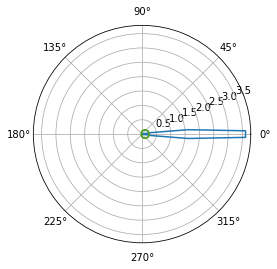

In [22]:
import seaborn as sns

angle_x = np.linspace(-np.pi,np.pi, 100)
p_alpha_2_true = norm_pdf(angle_x, 0.0, sigma_alpha_2)
p_alpha_2_fitted = norm_pdf(angle_x, 0.0, sigma_alpha2_new)
p_alpha_2_initial = norm_pdf(angle_x, 0.0, sigma_alpha2_0)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
#ax.plot(angle_x, 1/(2*np.pi)*np.ones(angle_x.shape))
ax.plot(angle_x, p_alpha_2_true)
ax.plot(angle_x, p_alpha_2_fitted)
ax.plot(angle_x, p_alpha_2_initial)

plt.savefig('/home/svensson/VMshared/HMM stuff/example_track6_sigma_alpha_all.png')

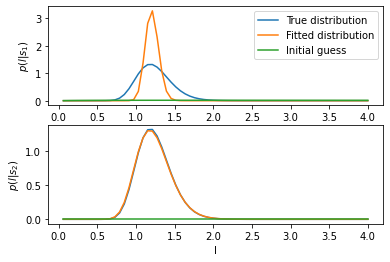

In [23]:
l_x = np.linspace(-2,4,100)
p_l_x_s1_true = lognorm_pdf(l_x, mu_l[0], sigma_l[0])
p_l_x_s1_fitted = lognorm_pdf(l_x, mu_l_new[0], sigma_l_new[0])
p_l_x_s1_initial = lognorm_pdf(l_x, mu_l0[0], sigma_l0[0])
plt.subplot(2,1,1)
plt.plot(l_x, p_l_x_s1_true, label='True distribution')
plt.plot(l_x, p_l_x_s1_fitted, label='Fitted distribution')
plt.plot(l_x, p_l_x_s1_initial, label='Initial guess')
plt.ylabel(r'$p(l|s_1)$')
plt.legend()

p_l_x_s2_true = lognorm_pdf(l_x, mu_l[1], sigma_l[1])
p_l_x_s2_fitted = lognorm_pdf(l_x, mu_l_new[1], sigma_l_new[1])
p_l_x_s2_initial = lognorm_pdf(l_x, mu_l0[1], sigma_l0[1])
plt.subplot(2,1,2)
plt.plot(l_x, p_l_x_s2_true)
plt.plot(l_x, p_l_x_s2_fitted)
plt.plot(l_x, p_l_x_s2_initial)
plt.ylabel(r'$p(l|s_2)$')
plt.xlabel(r'l')
plt.savefig('/home/svensson/VMshared/HMM stuff/example_track6_l_all.png')

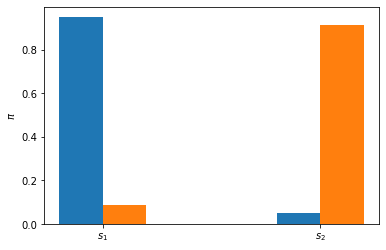

In [24]:
pos = np.array([1, 2])
width = 0.2
plt.bar(pos-width/2, pi, width)
plt.bar(pos+width/2, pi_new, width)
plt.ylabel(r'$\pi$')
plt.xticks([1,2], [r'$s_1$', r'$s_2$'])
plt.savefig('/home/svensson/VMshared/HMM stuff/example_track6_pi_all.png')

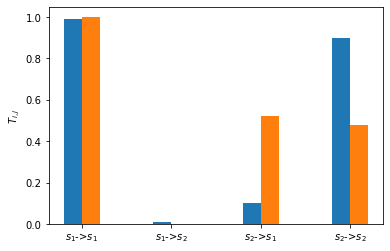

In [25]:
pos = np.array([1, 2, 3, 4])
width = 0.2
plt.bar(pos-width/2, T.flatten(), width)
plt.bar(pos+width/2, T_new.flatten(), width)
plt.ylabel(r'$T_{i,j}}$')
plt.xticks([1,2,3,4], [r'$s_1$->$s_1$', r'$s_1$->$s_2$', r'$s_2$->$s_1$', r'$s_2$->$s_2$'])
plt.savefig('/home/svensson/VMshared/HMM stuff/example_track6_T_all.png')

In [26]:
#def convert_to_cartesian(o):
#    X = np.zeros(o.shape, dtype=float)
#    X[:,1] = np.cumsum(o[:,1])
#    X[:,0] = np.cumsum(o[:,0]*np.cos(X[:,1]))
#    X[:,1] = np.cumsum(o[:,0]*np.sin(X[:,1]))
    
#    return X

def convert_to_planar(X, dt=1.0):
    #o = np.zeros([X.shape[0]-1 X.shape[1]])
    X_diff = np.diff(X, axis=0)
    l = np.sqrt(X_diff[:,0]**2+X_diff[:,1]**2)/dt + np.random. uniform(0.0, 0.000001)
    correct_idx = (l>0.0).nonzero()
    gamma = np.arctan2(X_diff[:,1],X_diff[:,0])
    alpha = np.diff(gamma)
    #X_r = np.roll(X, -1, axis=0)
    #X_r2 = np.roll(X_r, -1, axis=0)
    #u = X_r - X
    #v = X_r2 - X
    #alpha_nominator = [np.inner(x,y) for x, y in zip(u, v)] 
    #alpha_denom = np.sqrt(u[:,0]**2+u[:,1]**2)*np.sqrt(v[:,0]**2+v[:,1]**2)
    #alpha = np.sign((v-u)[:,1])*np.arccos(alpha_nominator/alpha_denom)
    alpha[alpha>np.pi] = alpha[alpha>np.pi] - 2*np.pi
    alpha[alpha<-np.pi] = alpha[alpha<-np.pi] + 2*np.pi
    #print(np.max(alpha))
    #print(np.min(alpha))
    #print(np.mean(alpha))
    #print((v-u)[:,1])
    
    return l[1:], alpha[:-2]
    

In [27]:
import pandas as pd

norm_data = pd.read_csv('/data/parralelcomputed_trackdata/norm/20180803_HEK_pJK26_GFP90ms_Triggered_2.3 cell1.xls_Ordner/Track_Data_Elongated_Truncated.csv', sep=',')
#norm_data = pd.read_csv('/home/svensson/asbdata_mount/publidata/JEmmert_data_BT/BachelorThesisData/norm/20180803_HEK_pJK26_GFP90ms_Triggered_2.6 cell2.xls_Ordner/Track_Data.xls', sep='\t')
noc_data = pd.read_csv('/data/parralelcomputed_trackdata/noc/20180802_HEK _pJK26_Noc_GFP90ms_Triggered_1_2 cell2.xls_Ordner/Track_Data_Elongated_Truncated.csv', sep=',')
#noc_data = pd.read_csv('/home/svensson/asbdata_mount/publidata/JEmmert_data_BT/BachelorThesisData/noc/20180802_HEK _pJK26_Noc_GFP90ms_Triggered_1_3 cell1.xls_Ordner/Track_Data.xls', sep='\t')

In [28]:
print(np.unique(norm_data['TRACK_ID']))

[    0     1     2 ... 15439 15441 15444]


In [29]:
track0 = norm_data.loc[norm_data['TRACK_ID']==0]

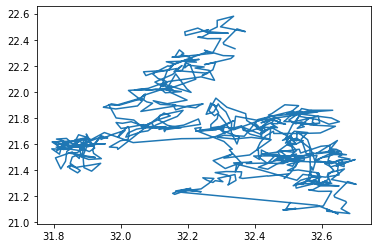

In [30]:
plt.plot(track0['POSITION_X'].iloc[0:], track0['POSITION_Y'].iloc[0:])

In [31]:
track0_noc = noc_data.loc[noc_data['TRACK_ID']==3]

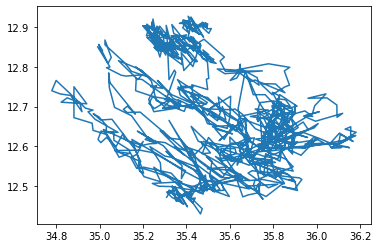

In [32]:
plt.plot(track0_noc['POSITION_X'].iloc[0:], track0_noc['POSITION_Y'].iloc[0:])

In [33]:
X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
l, alpha = convert_to_planar(X)
print(l.shape)
print(alpha.shape)
o = np.array([l[1:-1], alpha]).T
o_log = np.copy(o[:])
o_log[:,0] = np.log(o[:,0])

(698,)
(696,)


(array([ 5.,  7.,  3., 10.,  1.,  1.,  1.,  1.,  0.,  1.]),
 array([0.01000098, 0.02277632, 0.03555166, 0.048327  , 0.06110234,
        0.07387768, 0.08665302, 0.09942836, 0.1122037 , 0.12497904,
        0.13775438]),
 <BarContainer object of 10 artists>)

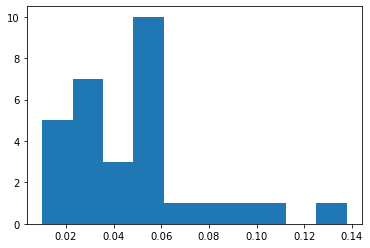

In [34]:
plt.hist(l[160:190])

(array([3., 1., 1., 5., 7., 2., 4., 2., 1., 4.]),
 array([-2.60663758, -2.03832707, -1.47001657, -0.90170606, -0.33339555,
         0.23491496,  0.80322546,  1.37153597,  1.93984648,  2.50815698,
         3.07646749]),
 <BarContainer object of 10 artists>)

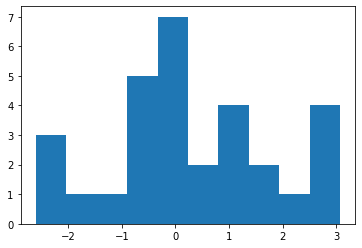

In [35]:
plt.hist(alpha[160:190])

[-0.97447833 -2.43310439 -0.41601732  0.28005744 -0.69252028  0.33691119
 -2.4872107  -0.52290624 -0.42556689  1.25676633  0.81018647  1.57079633
  3.07646749 -0.18087183  1.6018557   1.95925842  0.01931531 -0.01298628
 -2.60663758  1.33434018 -2.007935   -0.52240343  1.06476262  0.05992816
  0.20749623  2.53144177  0.18398571  2.97644398  2.65380654  0.16798995]


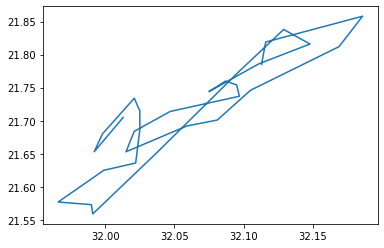

In [36]:
plt.plot(track0['POSITION_X'].iloc[160:190], track0['POSITION_Y'].iloc[160:190])
print(alpha[160:190])

In [37]:
X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
l, alpha = convert_to_planar(X)
print(l.shape)
#print(alpha.shape)
o = np.array([l[1:-1], alpha]).T
o_log = np.copy(o[:])
o_log[:,0] = np.log(o[:,0])
mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], T, pi, mu_l, sigma_l, sigma_alpha_2)
for ii in range(10):
    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)
    
T_new

(698,)


array([[9.99767675e-01, 2.32325190e-04],
       [9.81532382e-01, 1.84676182e-02]])

In [38]:
T = np.array([[0.8, 0.2],[0.3, 0.7]]) # assuming that Brownian motion is dominating
pi = np.array([0.95, 0.05]) # The prior probability of being in a s_1 and s_2 respectively
mu_l = np.array([-3.4, -3.4])
sigma_l = np.array([0.96, 0.96])
sigma_alpha_2 = 0.5
#print(abs(o[:,1])<0.05)

In [39]:
s_est, D, E = viterbi(T, pi, mu_l, sigma_l, sigma_alpha_2, o)
print(np.unique(s_est))

[0 1]


[0.04785403 0.22064718]
[ 0.03757668 -0.04730197]
[ 0.01170479 -0.34538252]
[0.01414222 0.00223214]
[ 0.05100009 -0.41601732]
[0.02376982 0.28005744]
[ 0.05879635 -0.69252028]
[0.0315754  0.33691119]
[0.10285922 0.01931531]
[ 0.01403576 -0.01298628]
[0.01941658 0.05992816]
[0.05869421 0.20749623]
[0.06403133 0.13656342]
[0.03546839 0.05687524]
[ 0.01253005 -0.05729384]
[0.01979908 0.13001306]
[ 0.01170479 -0.41875267]
[ 0.02319492 -0.45185261]
[0.07716226 0.47847354]
[ 0.07816018 -0.45964963]
[ 0.02692591 -0.18008434]
[0.08631347 0.52147779]
[0.04712758 0.27138447]
[ 0.09060914 -0.20139415]
[0.04386351 0.20344259]
[0.02158712 0.23411616]
[ 0.06334833 -0.18911075]
[ 0.04884679 -0.31413373]
[ 0.02500009 -0.3146137 ]
[0.02692591 0.39951549]
[0.05080363 0.27692572]
[0.00894436 0.12040599]
[0.0520097  0.64174055]
[ 0.05371229 -0.44441921]
[0.07409462 0.48606179]
[0.01414222 0.07150075]
[ 0.0544519  -0.22810263]
[0.05517255 0.28555467]
[0.03176485 0.12058711]
[0.03324163 0.25016765]
[0.04338

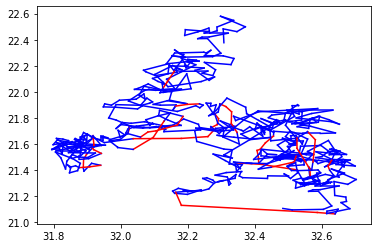

In [40]:
s_1_idx = (s_est==0)
s_2_idx = (s_est==1)
for ii in range(o.shape[0]-1):
    if s_est[ii+1] == 0:
        plt.plot(track0['POSITION_X'].iloc[ii+1:ii+3], track0['POSITION_Y'].iloc[ii+2:ii+4], c='blue')
    else:
        plt.plot(track0['POSITION_X'].iloc[ii+1:ii+3], track0['POSITION_Y'].iloc[ii+2:ii+4], c='red')
        print(o[ii+1])

In [41]:
from tqdm import tqdm
import json
import os
from json import JSONEncoder
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [48]:
with open('/data/norm_list.txt') as f_norm:
    norm_tables = f_norm.read().splitlines()

for table in tqdm(norm_tables[:]):
    #for d in tqdm(dirs[1:]):
    d = table[:table.rfind('/')]
    res_dic = {}
    counter = 0
    #print(d)
    try:
        norm_data = pd.read_csv(d + '/Track_Data_Elongated_Truncated.csv', sep=',')
        for track in np.unique(norm_data['TRACK_ID'])[:]:
            T = np.array([[0.8, 0.2],[0.3, 0.7]]) # assuming that Brownian motion is dominating
            pi = np.array([0.95, 0.05]) # The prior probability of being in a s_1 and s_2 respectively
            mu_l = np.array([-3.4, -3.4])
            sigma_l = np.array([0.96, 0.96])
            sigma_alpha_2 = 0.55
            try:
                #run_dic = {"track_id" : track}
                track0 = norm_data.loc[norm_data['TRACK_ID']==track]
                X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
                l, alpha = convert_to_planar(X)
                #print(l.shape)
                #print(alpha.shape)
                o = np.array([l[1:-1], alpha]).T
                o_log = np.copy(o[:])
                o_log[:,0] = np.log(o[:,0])
                run_dic = {"track_id" : str(track)}
                mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], T, pi, mu_l, sigma_l, sigma_alpha_2)
                converged = False
                iters = 0
                while not converged and iters < 1000:
                    iters += 1
                    mu_l_old = np.copy(mu_l_new)
                    sigma_l_old = np.copy(sigma_l_new)
                    pi_old = np.copy(pi_new)
                    T_old = np.copy(T_new)
                    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)
                    diff_m = mu_l_new - mu_l_old
                    diff_s = sigma_l_new - sigma_l_old
                    diff_p = pi_old - pi_new
                    diff_T = T_old - T_new
                    d_vector = [np.sqrt(diff_m.dot(diff_m)), 
                                np.sqrt(diff_s.dot(diff_s)), 
                                np.sqrt(diff_p.dot(diff_p)), 
                                np.linalg.norm(diff_T)]
                    #print(np.max(d_vector))
                    if np.max(d_vector) < 0.001:
                        converged = True
                          
                run_dic["mu_l"] = np.copy(mu_l_new[:]).tolist()
                run_dic["sigma_l"] = np.copy(sigma_l_new[:]).tolist()
                run_dic["sigma_alpha_2"] = np.copy(sigma_alpha2_new)
                run_dic["T"] = np.copy(T_new[:]).tolist()
                run_dic["pi"] = np.copy(pi_new[:]).tolist()
                res_dic[counter] = run_dic
                counter += 1 

                #print(sigma_l_new)
                #for kk in range(o.shape[0]//100):
                #    run_dic = {"track_id" : str(track)+'.'+str(kk)}
                #    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[kk*100:(kk+1)*100], T, pi, mu_l, sigma_l, sigma_alpha_2)
                #    for ii in range(10):
                #        mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[kk*100:(kk+1)*100], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)
                #    run_dic["mu_l"] = np.copy(mu_l_new[:]).tolist()
                #    run_dic["sigma_l"] = np.copy(sigma_l_new[:]).tolist()
                #    run_dic["sigma_alpha_2"] = np.copy(sigma_alpha2_new)
                #    run_dic["T"] = np.copy(T_new[:]).tolist()
                #    run_dic["pi"] = np.copy(pi_new[:]).tolist()
                #    res_dic_norm[counter] = run_dic
                #    counter += 1 
                #mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[(kk+1)*100:], T, pi, mu_l, sigma_l, sigma_alpha_2)
                #for ii in range(10):
                #    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[(kk+1)*100:], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)

                #run_dic = {"track_id" : str(track)+'.'+str(kk+1)}
                #run_dic["mu_l"] = np.copy(mu_l_new[:]).tolist()
                #run_dic["sigma_l"] = np.copy(sigma_l_new[:]).tolist()
                #run_dic["sigma_alpha_2"] = np.copy(sigma_alpha2_new)
                #run_dic["T"] = np.copy(T_new[:]).tolist()
                #run_dic["pi"] = np.copy(pi_new[:]).tolist()

                #res_dic_norm[counter] = run_dic
                #counter += 1 
            except:
                  continue

        with open(d+"/fitted_params.json", "w") as write_file:
            json.dump(res_dic, write_file, cls=NumpyArrayEncoder)
    except:
        continue

100%|██████████| 38/38 [11:55<00:00, 18.84s/it]


In [49]:
res_dic_norm

NameError: name 'res_dic_norm' is not defined

In [50]:
with open('/data/noc_list.txt') as f_noc:
    kop_tables = f_noc.read().splitlines()

for table in tqdm(kop_tables[:]):
    #for d in tqdm(dirs[1:]):
    d = table[:table.rfind('/')]
    res_dic = {}
    counter = 0
    #print(d)
    try:
        norm_data = pd.read_csv(d + '/Track_Data_Elongated_Truncated.csv', sep=',')
        for track in np.unique(norm_data['TRACK_ID'])[:]:
            T = np.array([[0.8, 0.2],[0.3, 0.7]]) # assuming that Brownian motion is dominating
            pi = np.array([0.95, 0.05]) # The prior probability of being in a s_1 and s_2 respectively
            mu_l = np.array([-3.4, -3.4])
            sigma_l = np.array([0.96, 0.96])
            sigma_alpha_2 = 0.55
            try:
                #run_dic = {"track_id" : track}
                track0 = norm_data.loc[norm_data['TRACK_ID']==track]
                X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
                l, alpha = convert_to_planar(X)
                #print(l.shape)
                #print(alpha.shape)
                o = np.array([l[1:-1], alpha]).T
                o_log = np.copy(o[:])
                o_log[:,0] = np.log(o[:,0])
                run_dic = {"track_id" : str(track)}
                mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], T, pi, mu_l, sigma_l, sigma_alpha_2)
                converged = False
                iters = 0
                while not converged and iters < 1000:
                    iters += 1
                    mu_l_old = np.copy(mu_l_new)
                    sigma_l_old = np.copy(sigma_l_new)
                    pi_old = np.copy(pi_new)
                    T_old = np.copy(T_new)
                    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)
                    diff_m = mu_l_new - mu_l_old
                    diff_s = sigma_l_new - sigma_l_old
                    diff_p = pi_old - pi_new
                    diff_T = T_old - T_new
                    d_vector = [np.sqrt(diff_m.dot(diff_m)), 
                                np.sqrt(diff_s.dot(diff_s)), 
                                np.sqrt(diff_p.dot(diff_p)), 
                                np.linalg.norm(diff_T)]
                    #print(np.max(d_vector))
                    if np.max(d_vector) < 0.001:
                        converged = True
                          
                run_dic["mu_l"] = np.copy(mu_l_new[:]).tolist()
                run_dic["sigma_l"] = np.copy(sigma_l_new[:]).tolist()
                run_dic["sigma_alpha_2"] = np.copy(sigma_alpha2_new)
                run_dic["T"] = np.copy(T_new[:]).tolist()
                run_dic["pi"] = np.copy(pi_new[:]).tolist()
                res_dic[counter] = run_dic
                counter += 1 

                #print(sigma_l_new)
                #for kk in range(o.shape[0]//100):
                #    run_dic = {"track_id" : str(track)+'.'+str(kk)}
                #    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[kk*100:(kk+1)*100], T, pi, mu_l, sigma_l, sigma_alpha_2)
                #    for ii in range(10):
                #        mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[kk*100:(kk+1)*100], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)
                #    run_dic["mu_l"] = np.copy(mu_l_new[:]).tolist()
                #    run_dic["sigma_l"] = np.copy(sigma_l_new[:]).tolist()
                #    run_dic["sigma_alpha_2"] = np.copy(sigma_alpha2_new)
                #    run_dic["T"] = np.copy(T_new[:]).tolist()
                #    run_dic["pi"] = np.copy(pi_new[:]).tolist()
                #    res_dic_norm[counter] = run_dic
                #    counter += 1 
                #mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[(kk+1)*100:], T, pi, mu_l, sigma_l, sigma_alpha_2)
                #for ii in range(10):
                #    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[(kk+1)*100:], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)

                #run_dic = {"track_id" : str(track)+'.'+str(kk+1)}
                #run_dic["mu_l"] = np.copy(mu_l_new[:]).tolist()
                #run_dic["sigma_l"] = np.copy(sigma_l_new[:]).tolist()
                #run_dic["sigma_alpha_2"] = np.copy(sigma_alpha2_new)
                #run_dic["T"] = np.copy(T_new[:]).tolist()
                #run_dic["pi"] = np.copy(pi_new[:]).tolist()

                #res_dic_norm[counter] = run_dic
                #counter += 1 
            except:
                  continue

        with open(d+"/fitted_params.json", "w") as write_file:
            json.dump(res_dic, write_file, cls=NumpyArrayEncoder)
    except:
        continue    

100%|██████████| 129/129 [22:24<00:00, 10.43s/it]


In [51]:
dirs = []
[dirs.append(d[0]) for d in os.walk('/data/parralelcomputed_trackdata/ko pex/')]
#print(dirs)
with open('/data/Listekopex.txt') as f_kop:
    kop_tables = f_kop.read().splitlines()

for table in tqdm(kop_tables[:]):
    #for d in tqdm(dirs[1:]):
    d = table[:table.rfind('/')]
    res_dic = {}
    counter = 0
    #print(d)
    try:
        norm_data = pd.read_csv(d + '/Track_Data_Elongated_Truncated.csv', sep=',')
        for track in np.unique(norm_data['TRACK_ID'])[:]:
            T = np.array([[0.8, 0.2],[0.3, 0.7]]) # assuming that Brownian motion is dominating
            pi = np.array([0.95, 0.05]) # The prior probability of being in a s_1 and s_2 respectively
            mu_l = np.array([-3.4, -3.4])
            sigma_l = np.array([0.96, 0.96])
            sigma_alpha_2 = 0.55
            try:
                #run_dic = {"track_id" : track}
                track0 = norm_data.loc[norm_data['TRACK_ID']==track]
                X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
                l, alpha = convert_to_planar(X)
                #print(l.shape)
                #print(alpha.shape)
                o = np.array([l[1:-1], alpha]).T
                o_log = np.copy(o[:])
                o_log[:,0] = np.log(o[:,0])
                run_dic = {"track_id" : str(track)}
                mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], T, pi, mu_l, sigma_l, sigma_alpha_2)
                converged = False
                iters = 0
                while not converged and iters < 1000:
                    iters += 1
                    mu_l_old = np.copy(mu_l_new)
                    sigma_l_old = np.copy(sigma_l_new)
                    pi_old = np.copy(pi_new)
                    T_old = np.copy(T_new)
                    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[:], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)
                    diff_m = mu_l_new - mu_l_old
                    diff_s = sigma_l_new - sigma_l_old
                    diff_p = pi_old - pi_new
                    diff_T = T_old - T_new
                    d_vector = [np.sqrt(diff_m.dot(diff_m)), 
                                np.sqrt(diff_s.dot(diff_s)), 
                                np.sqrt(diff_p.dot(diff_p)), 
                                np.linalg.norm(diff_T)]
                    #print(np.max(d_vector))
                    if np.max(d_vector) < 0.001:
                        converged = True
                          
                run_dic["mu_l"] = np.copy(mu_l_new[:]).tolist()
                run_dic["sigma_l"] = np.copy(sigma_l_new[:]).tolist()
                run_dic["sigma_alpha_2"] = np.copy(sigma_alpha2_new)
                run_dic["T"] = np.copy(T_new[:]).tolist()
                run_dic["pi"] = np.copy(pi_new[:]).tolist()
                res_dic[counter] = run_dic
                counter += 1 

                #print(sigma_l_new)
                #for kk in range(o.shape[0]//100):
                #    run_dic = {"track_id" : str(track)+'.'+str(kk)}
                #    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[kk*100:(kk+1)*100], T, pi, mu_l, sigma_l, sigma_alpha_2)
                #    for ii in range(10):
                #        mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[kk*100:(kk+1)*100], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)
                #    run_dic["mu_l"] = np.copy(mu_l_new[:]).tolist()
                #    run_dic["sigma_l"] = np.copy(sigma_l_new[:]).tolist()
                #    run_dic["sigma_alpha_2"] = np.copy(sigma_alpha2_new)
                #    run_dic["T"] = np.copy(T_new[:]).tolist()
                #    run_dic["pi"] = np.copy(pi_new[:]).tolist()
                #    res_dic_norm[counter] = run_dic
                #    counter += 1 
                #mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[(kk+1)*100:], T, pi, mu_l, sigma_l, sigma_alpha_2)
                #for ii in range(10):
                #    mu_l_new, sigma_l_new, sigma_alpha2_new, T_new, pi_new = Baum_Welch(o_log[(kk+1)*100:], T_new, pi_new, mu_l_new, sigma_l_new, sigma_alpha2_new)

                #run_dic = {"track_id" : str(track)+'.'+str(kk+1)}
                #run_dic["mu_l"] = np.copy(mu_l_new[:]).tolist()
                #run_dic["sigma_l"] = np.copy(sigma_l_new[:]).tolist()
                #run_dic["sigma_alpha_2"] = np.copy(sigma_alpha2_new)
                #run_dic["T"] = np.copy(T_new[:]).tolist()
                #run_dic["pi"] = np.copy(pi_new[:]).tolist()

                #res_dic_norm[counter] = run_dic
                #counter += 1 
            except:
                  continue

        with open(d+"/fitted_params.json", "w") as write_file:
            json.dump(res_dic, write_file, cls=NumpyArrayEncoder)
    except:
        continue    
    

100%|██████████| 134/134 [05:26<00:00,  2.44s/it]


In [262]:

N = 0
pi_tot = np.zeros(2)
T_tot = np.zeros((2,2))
mu_tot = np.zeros(2)
sigma_tot = np.zeros(2)
for key in res_dic_norm.keys():
    if not np.isnan(res_dic_norm[key]['pi']).any():
        if res_dic_norm[key]['T'][1,1]>0.5:
            N += 1
            pi_tot += res_dic_norm[key]['pi']
            mu_tot += res_dic_norm[key]['mu_l']
            sigma_tot += res_dic_norm[key]['sigma_l']
            T_tot[0] += res_dic_norm[key]['pi'][0]*res_dic_norm[key]['T'][0]
            T_tot[1] += res_dic_norm[key]['pi'][1]*res_dic_norm[key]['T'][1]
            #T_tot += res_dic_norm[key]['T']
    #
    #    print(res_dic[key])
T_tot[0] = T_tot[0]/np.sum(T_tot[0])
T_tot[1] = T_tot[1]/np.sum(T_tot[1])

print(N)
print(pi_tot/N)
print(mu_tot/N)
print(sigma_tot/N)
print(T_tot)

27
[0.86066546 0.13933454]
[-3.15402748 -1.94613138]
[0.74234052 0.46378546]
[[0.97589017 0.02410983]
 [0.3013096  0.6986904 ]]


In [263]:
N = 0
pi_tot = np.zeros(2)
T_tot = np.zeros((2,2))
mu_tot = np.zeros(2)
sigma_tot = np.zeros(2)
for key in res_dic_noc.keys():
    #if not np.isnan(res_dic_noc[key]['pi']).any():
    if res_dic_noc[key]['T'][1,1]>0.5:
        N += 1
        pi_tot += res_dic_noc[key]['pi']
        mu_tot += res_dic_noc[key]['mu_l']
        sigma_tot += res_dic_norm[key]['sigma_l']
        T_tot[0] += res_dic_noc[key]['pi'][0]*res_dic_noc[key]['T'][0]
        T_tot[1] += res_dic_noc[key]['pi'][1]*res_dic_noc[key]['T'][1]
        #T_tot += res_dic_noc[key]['T']
    #
    #    print(res_dic[key])
T_tot[0] = T_tot[0]/np.sum(T_tot[0])
T_tot[1] = T_tot[1]/np.sum(T_tot[1])

print(N)
print(pi_tot/N)
print(mu_tot/N)
print(sigma_tot/N)
print(T_tot)

5
[0.89959474 0.10040526]
[-3.01552113 -2.58535408]
[0.687168   0.51106688]
[[0.98415671 0.01584329]
 [0.46099823 0.53900177]]


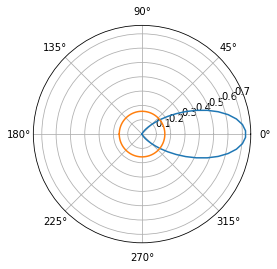

In [47]:
angle_x = np.linspace(-np.pi,np.pi, 100)

p_alpha_2_fitted = norm_pdf(angle_x, 0.0, 0.55)
p_alpha_2_uniform = 1/(2*np.pi)*np.ones(100)#norm_pdf(angle_x, 0.0, sigma_alpha2_0)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
#ax.plot(angle_x, 1/(2*np.pi)*np.ones(angle_x.shape))
ax.plot(angle_x, p_alpha_2_fitted)
ax.plot(angle_x, p_alpha_2_uniform)
plt.savefig('/home/svensson/VMshared/HMM stuff/sigma_alpha_025.png')

In [54]:
N_straight = 0
for key in res_dic_norm.keys():
    if not np.isnan(res_dic_norm[key]['pi']).any():
        if res_dic_norm[key]['T'][1,1]>0.5:
            N_straight += 1
            print(key)
            print(res_dic_norm[key])
            try:
                track0 = norm_data.loc[norm_data['TRACK_ID']==int(res_dic_norm[key]['track_id'][:res_dic_norm[key]['track_id'].rfind('.')])]
            except:
                track0 = norm_data.loc[norm_data['TRACK_ID']== res_dic_norm[key]['track_id']]
            X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
            l, alpha = convert_to_planar(X)
            o = np.array([l[1:-1], alpha]).T
            s_est, D, E = viterbi(res_dic_norm[key]['T'], res_dic_norm[key]['pi'], res_dic_norm[key]['mu_l'], res_dic_norm[key]['sigma_l'], res_dic_norm[key]['sigma_alpha_2'], o)
            s_1_idx = (s_est==0)
            s_2_idx = (s_est==1)
            #print(X.shape)
            for ii in range(X.shape[0]-5):
                if s_est[ii+1] == 0:
                    plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='blue')
                else:
                    plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='red')
            plt.savefig('norm_Triggered_2.3cell1_track%s.png'%res_dic_norm[key]['track_id'])
            plt.close('all')
print(N_straight)

45
{'track_id': '13.0', 'mu_l': array([-4.13217756, -2.26285993]), 'sigma_l': array([0.68689514, 0.39559011]), 'sigma_alpha_2': array(0.25), 'T': array([[0.98814885, 0.01185115],
       [0.11477099, 0.88522901]]), 'pi': array([0.86143201, 0.13856799])}
106
{'track_id': '41.1', 'mu_l': array([-4.46024834, -3.29090607]), 'sigma_l': array([0.75526512, 0.39010622]), 'sigma_alpha_2': array(0.25), 'T': array([[0.97581629, 0.02418371],
       [0.47375529, 0.52624471]]), 'pi': array([0.91253093, 0.08746907])}
161
{'track_id': '65.0', 'mu_l': array([-2.64136053, -2.44844592]), 'sigma_l': array([0.58694771, 0.16342796]), 'sigma_alpha_2': array(0.25), 'T': array([[9.99999975e-01, 2.51219642e-08],
       [4.98979335e-01, 5.01020665e-01]]), 'pi': array([0.95396323, 0.04603677])}
397
{'track_id': '204.0', 'mu_l': array([-2.94049119, -2.28972463]), 'sigma_l': array([0.6054994 , 0.07044559]), 'sigma_alpha_2': array(0.25), 'T': array([[0.98102384, 0.01897616],
       [0.45694291, 0.54305709]]), 'pi': a

ZeroDivisionError: division by zero

In [21]:
track0 = norm_data.loc[norm_data['TRACK_ID']==2366]
X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
l, alpha = convert_to_planar(X)
o = np.array([l[1:-1], alpha]).T
s_est, D, E = viterbi(res_dic_norm[1538]['T'], res_dic_norm[1538]['pi'], res_dic_norm[1538]['mu_l'], res_dic_norm[1538]['sigma_l'], res_dic_norm[1538]['sigma_alpha_2'], o)


NameError: name 'norm_data' is not defined

(100, 2)


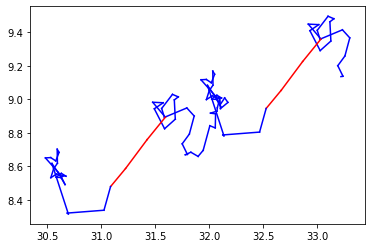

In [355]:
s_1_idx = (s_est==0)
s_2_idx = (s_est==1)
print(X.shape)
for ii in range(X.shape[0]-5):
    if s_est[ii+1] == 0:
        plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='blue')
    else:
        plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='red')

In [654]:
for key in res_dic_noc.keys():
    if not np.isnan(res_dic_noc[key]['pi']).any():
        if res_dic_noc[key]['T'][1,1]>0.5:
            print(key)
            print(res_dic_noc[key])
            try:
                track0 = noc_data.loc[noc_data['TRACK_ID']==int(res_dic_noc[key]['track_id'][:res_dic_noc[key]['track_id'].rfind('.')])]
                X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
                l, alpha = convert_to_planar(X)
                o = np.array([l[1:-1], alpha]).T
                s_est, D, E = viterbi(res_dic_noc[key]['T'], res_dic_noc[key]['pi'], res_dic_noc[key]['mu_l'], res_dic_noc[key]['sigma_l'], res_dic_noc[key]['sigma_alpha_2'], o)
                s_1_idx = (s_est==0)
                s_2_idx = (s_est==1)
                #print(X.shape)
                for ii in range(X.shape[0]-5):
                    if s_est[ii+1] == 0:
                        plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='blue')
                    else:
                        plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='red')
            except:
                continue
            plt.savefig('noc_Triggered_1.2cell2_track%s.png'%res_dic_noc[key]['track_id'])
            plt.close('all')
#plt.savefig('noc_tracks_s2_Triggered_2_4.png')
            #plt.close('all')

175
{'track_id': '99.0', 'mu_l': array([-3.7394956 , -3.08975579]), 'sigma_l': array([0.76915309, 0.30573864]), 'sigma_alpha_2': array(0.45), 'T': array([[0.95516974, 0.04483026],
       [0.49453692, 0.50546308]]), 'pi': array([0.77944938, 0.22055062])}
2067
{'track_id': '10739.0', 'mu_l': array([-2.59717831, -1.8968118 ]), 'sigma_l': array([0.62325179, 0.1189931 ]), 'sigma_alpha_2': array(0.45), 'T': array([[0.98109757, 0.01890243],
       [0.46355266, 0.53644734]]), 'pi': array([0.87186657, 0.12813343])}


In [339]:
track0 = noc_data.loc[noc_data['TRACK_ID']==12100]
X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
l, alpha = convert_to_planar(X)
o = np.array([l[1:-1], alpha]).T
s_est, D, E = viterbi(res_dic_noc[3289]['T'], res_dic_noc[3289]['pi'], res_dic_noc[3289]['mu_l'], res_dic_noc[3289]['sigma_l'], res_dic_noc[3289]['sigma_alpha_2'], o)


(100, 2)


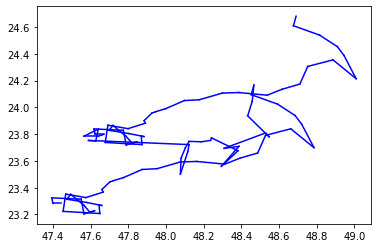

In [340]:
s_1_idx = (s_est==0)
s_2_idx = (s_est==1)
print(X.shape)
for ii in range(X.shape[0]-5):
    if s_est[ii+1] == 0:
        plt.plot(X[ii+2:ii+4,0], X[ii:ii+2,1], c='blue')
    else:
        plt.plot(X[ii+2:ii+4,0], X[ii:ii+2,1], c='red')

In [263]:
res_dic_norm[767]['sigma_alpha_2']

array(0.2231802)

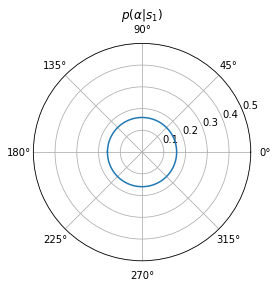

In [445]:
angle_x = np.linspace(-np.pi,np.pi, 100)
p_alpha_2_fitted = norm_pdf(angle_x, 0.0, res_dic_norm[33]['sigma_alpha_2'])
#p_alpha_2_initial = norm_pdf(angle_x, 0.0, sigma_alpha_2)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angle_x, 1/(2*np.pi)*np.ones(angle_x.shape))

#ax.plot(angle_x, p_alpha_2_fitted)
#ax.plot(angle_x, p_alpha_2_initial)
plt.axis(ymax=0.5)
plt.title(r'$p(\alpha|s_1)$')
plt.savefig('/home/svensson/VMshared/HMM stuff/p_alpha_1_ex.png')

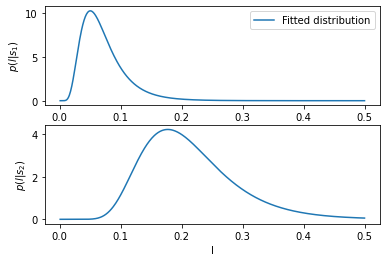

In [451]:
l_x = np.linspace(0,0.5,500)
p_l_x_s1_fitted = lognorm_pdf(l_x, res_dic_norm[1082]['mu_l'][0], res_dic_norm[1082]['sigma_l'][0])
p_l_x_s1_initial = lognorm_pdf(l_x, mu_l[0], sigma_l0[0])
plt.subplot(2,1,1)
plt.plot(l_x, p_l_x_s1_fitted, label='Fitted distribution')
#plt.plot(l_x, p_l_x_s1_initial, label='Initial guess')
plt.ylabel(r'$p(l|s_1)$')
plt.legend()

p_l_x_s2_fitted = lognorm_pdf(l_x, res_dic_norm[1082]['mu_l'][1], res_dic_norm[1082]['sigma_l'][1])
p_l_x_s2_initial = lognorm_pdf(l_x, mu_l[1], sigma_l[1])
plt.subplot(2,1,2)
plt.plot(l_x, p_l_x_s2_fitted)
#plt.plot(l_x, p_l_x_s2_initial)
plt.ylabel(r'$p(l|s_2)$')
plt.xlabel(r'l')
plt.savefig('/home/svensson/VMshared/HMM stuff/p_l_ex.png')

([<matplotlib.axis.XTick at 0x7fda9a499ed0>,
 [Text(1, 0, '$s_1$'), Text(2, 0, '$s_2$')])

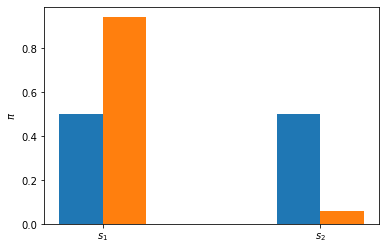

In [349]:
pos = np.array([1, 2])
width = 0.2
plt.bar(pos-width/2, pi, width)
plt.bar(pos+width/2, pi_new, width)
plt.ylabel(r'$\pi$')
plt.xticks([1,2], [r'$s_1$', r'$s_2$'])

([<matplotlib.axis.XTick at 0x7fda9ab378d0>,
 [Text(1, 0, '$s_1$->$s_1$'),
  Text(2, 0, '$s_1$->$s_2$'),
  Text(3, 0, '$s_2$->$s_1$'),
  Text(4, 0, '$s_2$->$s_2$')])

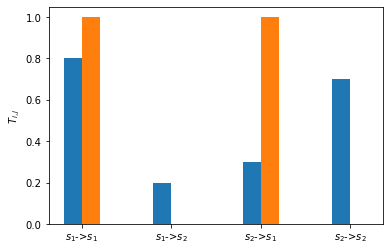

In [350]:
pos = np.array([1, 2, 3, 4])
width = 0.2
plt.bar(pos-width/2, T.flatten(), width)
plt.bar(pos+width/2, T_new.flatten(), width)
plt.ylabel(r'$T_{i,j}}$')
plt.xticks([1,2,3,4], [r'$s_1$->$s_1$', r'$s_1$->$s_2$', r'$s_2$->$s_1$', r'$s_2$->$s_2$'])

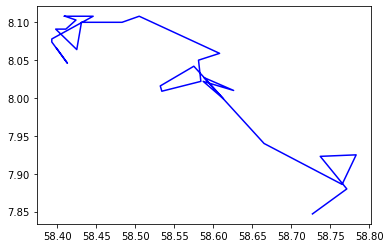

In [213]:
plt.plot(track0['POSITION_X'].iloc[160:190], track0['POSITION_Y'].iloc[160:190], c='blue')

In [214]:
X_test = np.array([track0['POSITION_X'].iloc[160:190], track0['POSITION_Y'].iloc[160:190]]).T
X_diff = np.diff(X_test, axis=0)
print(X_diff)
gamma = np.arctan2((X_diff[:,1]),X_diff[:,0])
print(gamma)
alpha = np.diff(gamma)
print(alpha)

[[ 0.014 -0.02 ]
 [-0.02   0.028]
 [ 0.     0.004]
 [ 0.053  0.03 ]
 [-0.037  0.   ]
 [ 0.001  0.   ]
 [ 0.014 -0.005]
 [-0.013 -0.012]
 [-0.013  0.   ]
 [ 0.027 -0.027]
 [ 0.006  0.036]
 [ 0.052  0.   ]
 [ 0.022  0.008]
 [ 0.103 -0.049]
 [-0.027 -0.009]
 [ 0.003 -0.028]
 [-0.05  -0.013]
 [-0.002  0.007]
 [ 0.043  0.026]
 [ 0.038 -0.043]
 [-0.026  0.023]
 [ 0.039 -0.012]
 [-0.038  0.017]
 [ 0.077 -0.087]
 [ 0.1   -0.054]
 [ 0.018  0.039]
 [-0.046 -0.002]
 [ 0.034 -0.043]
 [-0.044 -0.033]]
[-0.96007036  2.19104581  1.57079633  0.51507282  3.14159265  0.
 -0.34302394 -2.39617318  3.14159265 -0.78539816  1.40564765  0.
  0.348771   -0.44404228 -2.8198421  -1.46406065 -2.8872246   1.84909599
  0.54383246 -0.84704833  2.41734265 -0.29849893  2.7209293  -0.84629837
 -0.49513326  1.13838855 -3.09814176 -0.90175333 -2.49809154]
[ 3.15111618 -0.62024949 -1.05572351  2.62651984 -3.14159265 -0.34302394
 -2.05314924  5.53776583 -3.92699082  2.19104581 -1.40564765  0.348771
 -0.79281328 -2.37579982

array([5, 1, 2, 3, 4])